In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# NLP libraries
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

# ML libraries
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import joblib

# Neural Networks libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, Dropout, Bidirectional,Flatten
from keras.models import Sequential
     
# Visualization librations
import matplotlib.pyplot as plt
import seaborn as sns

# Word Cloud libraries
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
import requests

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# lemmatizer
lm = WordNetLemmatizer()

# Checks if given word contains a special character
def contains_special(word):
    for char in word:
        if char.isnumeric() or (not char.isalnum()):
            return True
    return False

# process sentences
def process_sentences(sentence):
    # tokenize, lemmatize, and remove special characters
    processed = [lm.lemmatize(word.lower()) for word in nltk.word_tokenize(sentence)
          # make sure no strings that contain only numeric characters
          if not contains_special(word)]
    return ' '.join(processed)

In [3]:
# get data
df = pd.read_csv('tweets.csv')
# drop duplicates
df.drop_duplicates(inplace =True)
X = df['text']
y = df['target']

In [4]:
y.value_counts()

target
0    9256
1    2114
Name: count, dtype: int64

In [5]:
# text pre-processing
X = X.apply(process_sentences)

In [6]:
X[0]

'communal violence in bhainsa telangana stone were pelted on muslim house and some house and vehicle were set'

In [7]:

# Convert text data into BoW features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
vocabulary = vectorizer.vocabulary_
print('Vocab size: ' + str(len(vocabulary)))
joblib.dump(vectorizer, "vectorizer.pk1")


Vocab size: 16985


['vectorizer.pk1']

In [8]:
vocabulary['house']

6955

In [9]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.25, random_state=1)


In [10]:
# Naive Bayes
def naive_bayes(X_train, X_test, y_train, y_test):
    # increased max iter to prevent early time out
    clf = MultinomialNB().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test,
                                    y_pred))
    
    # save model
    joblib.dump(clf, "naive_bayes_model.pk1")

    return y_pred

print('Naive Bayes\n')
ypred_nb = naive_bayes(X_train, X_test, y_train, y_test)

Naive Bayes

accuracy: 0.8695040450228632
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2321
           1       0.65      0.62      0.64       522

    accuracy                           0.87      2843
   macro avg       0.78      0.77      0.78      2843
weighted avg       0.87      0.87      0.87      2843



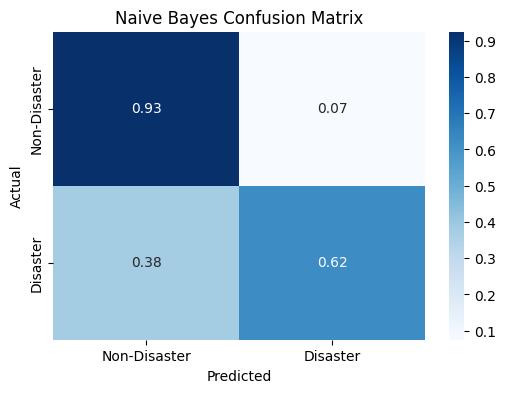

In [11]:
#Plot Naive Bayes confusion matrix
cf_matrix = confusion_matrix(y_test, ypred_nb)
categories = ['Non-Disaster', 'Disaster']
cf_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize= (6,4))
sns.heatmap(cf_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()


In [12]:
# Logistic Regression
def logistic_regression(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    # scale data to reduce ranges
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # increased max iter to prevent early time out
    clf = LogisticRegression(max_iter = 500).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test,
                                    y_pred))

    # save model
    joblib.dump(clf, "logistic_regression_model.pk1")

    return y_pred

print('Logistic Regression\n')
ypred_lr = logistic_regression(X_train, X_test, y_train, y_test)

Logistic Regression

accuracy: 0.8712627506155469
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2321
           1       0.67      0.58      0.62       522

    accuracy                           0.87      2843
   macro avg       0.79      0.76      0.77      2843
weighted avg       0.87      0.87      0.87      2843



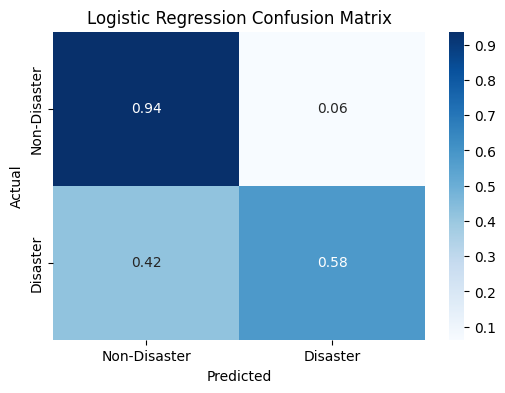

In [13]:
#Plot Logistic Regression confusion matrix
cf_matrix = confusion_matrix(y_test, ypred_lr)
categories = ['Non-Disaster', 'Disaster']
cf_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize= (6,4))
sns.heatmap(cf_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [14]:
# get data
df = pd.read_csv('tweets.csv')
# drop duplicates
df.drop_duplicates(inplace =True)

X = df['text']
y = df['target']

# text pre-pro|cessing
X = X.apply(process_sentences)

In [15]:
from gensim.models import Word2Vec

def get_embeddings(data, size):
  return Word2Vec(sentences=data, vector_size=size, window=5, min_count=1,
                 sg=1)

# get a mapping of word -> embedding, word_index -> embedding
def map_embeddings(model, tokenizer):
    # all vocab
    vocab = list(model.wv.index_to_key)
    # word to word index map
    word_index = tokenizer.word_index
    # word to embedding map
    word_embed = {}
    # word index to embedding map
    index_embed = {}

    for w in vocab:
        # get current word's embedding
        e = model.wv[w]
        # set embedding for current word
        word_embed[w] = e
        # set embedding for current word index
        curr_index = word_index[w]
        index_embed[curr_index] = e
    return word_embed, index_embed

# pre-padding data to fixed length token for NN input
def pre_padding(encoded, seq_length, model):
    if model == "rnn":
      X = []
      for row in encoded:
          for i in range(1, len(row) - 1):
              X.append(row[:i])
    X = pad_sequences(encoded, maxlen = seq_length)
    return X

# convert data into 3D matrix (total rows, max sequence length, embedding size) for LSTM
def reshape_data(X, index_embed):
  reshaped = []
  for seq in X:
    # get embeddings for each word index in sequence
    seq_embed = [index_embed[index] for index in seq]
    reshaped.append(seq_embed)
  # convert to numpy array
  return np.array(reshaped)


def data_generator(X, y, num_sequences, index_embed, model) -> (list,list):
    i = 0
    while i < len(X):
        # end range of data for current batch
        end_index = i + num_sequences
        # reached end of our dataset
        if end_index >= len(X) - 1:
            i = 0
            end_index = i + num_sequences

        if model == "ffnn":
          # we need to flatten our inputs for a feedforward network
          inputs = [input.flatten() for input in X[i:end_index]]
        else:
          inputs = [val for val in X[i:end_index]]

        outputs = [val for val in y[i:end_index]]
        yield np.array(inputs), np.array(outputs)
        i += num_sequences

     

In [16]:

# process data for Gensim's Word2Vec
X = X.apply(nltk.word_tokenize)
word2vec = get_embeddings(X,200)
vocab_size = len(word2vec.wv.index_to_key)
print('Vocab size {}'.format(vocab_size))
joblib.dump(word2vec, "word2vec_vectorizer.pk1")


Vocab size 17020


['word2vec_vectorizer.pk1']

In [17]:
word2vec.wv.most_similar('people', topn = 10)


[('those', 0.9499421715736389),
 ('many', 0.9135306477546692),
 ('these', 0.9077861905097961),
 ('animal', 0.8899538516998291),
 ('american', 0.8842775821685791),
 ('other', 0.8804814219474792),
 ('innocent', 0.8797262907028198),
 ('their', 0.8781307935714722),
 ('hostage', 0.8778972029685974),
 ('displaced', 0.8654568791389465)]

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
embedding_size = 200
# embeddings
word_embed, index_embed = map_embeddings(word2vec, tokenizer)
# set embeddings for zero index
index_embed[0] = np.zeros((embedding_size,))
word_embed[''] = np.zeros((embedding_size,))
vocab_size = len(word_embed.keys())

In [19]:
# encode data into word indexes
encoded_data = tokenizer.texts_to_sequences(X)
# max sequence length
max_sequence_length = np.max([len(seq) for seq in encoded_data])
# prepadding on data
ffnn_pre_padded_X = pre_padding(encoded_data, max_sequence_length, "ffnn")
rnn_pre_padded_X = pre_padding(encoded_data, max_sequence_length, "rnn")

In [20]:
# convert pre-padded and encoded data into 3D shape for FFNN input
ffnn_X = reshape_data(ffnn_pre_padded_X, index_embed)
print(ffnn_X.shape)

(11370, 30, 200)


In [21]:

# convert pre-padded and encoded data into 3D shape for FFNN input
rnn_X = reshape_data(rnn_pre_padded_X, index_embed)
print(rnn_X.shape)
     

(11370, 30, 200)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(ffnn_X, y, test_size=0.25, random_state=1)


In [23]:
# Feedforward Neural Network
# hyperparameters
epochs = 10
batches = 256
steps = len(X_train)//batches

# data generator
train_generator = data_generator(X_train, y_train, batches, index_embed, "ffnn")

# architecture
model = Sequential()
model.add(Dense(200, activation='relu', input_dim = max_sequence_length * embedding_size))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
# sigmoid for binary classification
model.add(Dense(units= 1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x= train_generator,
          steps_per_epoch= steps,
          epochs= epochs, verbose = 1)

print(model.output)

# save model
joblib.dump(model, "feed_forward_model.pk1")




Epoch 1/10


33/33 [==============================] - 3s 30ms/step - loss: 0.4303 - accuracy: 0.8208
Epoch 2/10
33/33 [==============================] - 1s 29ms/step - loss: 0.3615 - accuracy: 0.8501
Epoch 3/10
33/33 [==============================] - 1s 29ms/step - loss: 0.3461 - accuracy: 0.8581
Epoch 4/10
33/33 [==============================] - 1s 41ms/step - loss: 0.3358 - accuracy: 0.8625
Epoch 5/10
33/33 [==============================] - 1s 42ms/step - loss: 0.3251 - accuracy: 0.8673
Epoch 6/10
33/33 [==============================] - 1s 42ms/step - loss: 0.3186 - accuracy: 0.8687
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.3140 - accuracy: 0.8712
Epoch 8/10
33/33 [==============================] - 1s 39ms/step - loss: 0.3075 - accuracy: 0.8767
Epoch 9/10
33/33 [==============================] - 1s 40ms/step - loss: 0.2946 - accuracy: 0.8809
Epoch 10/10
33/33 [==============================] - 1s 40ms/step - loss: 0.2832 - accuracy: 0.8846
Keras

['feed_forward_model.pk1']

89/89 [==============================] - 1s 7ms/step


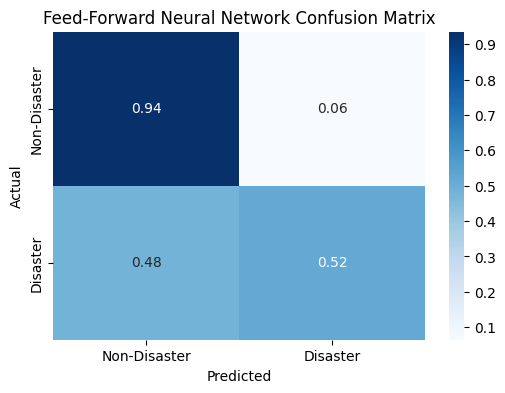

0.8586000703482237


In [24]:
#Plot Feed-foward Neural Network confusion matrix
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
predictions = model.predict(X_test_reshaped)
threshold = 0.5
y_pred = (predictions > threshold).astype(int)
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ['Non-Disaster', 'Disaster']
cf_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize= (6,4))
sns.heatmap(cf_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Feed-Forward Neural Network Confusion Matrix')
plt.show()

accuracy = (cf_matrix[0, 0] + cf_matrix[1, 1]) / np.sum(cf_matrix)  # Calculate accuracy

print(accuracy)



In [25]:
X_train, X_test, y_train, y_test = train_test_split(rnn_X, y, test_size=0.25, random_state=1)

In [26]:
# LSTM
# hyperparameters
epochs = 5
batches = 256
steps = len(X_train)//batches

# Data generator
train_generator = data_generator(X_train, y_train, batches, index_embed, "rnn")

# Architecture
model = Sequential()
# LSTM input layer
model.add(LSTM(200, input_shape=(max_sequence_length, embedding_size),return_sequences=True))
# Dropout layer to prevent overfitting
model.add(Dropout(0.2))
# LSTM layer
model.add(LSTM(128, input_shape=(max_sequence_length, embedding_size),return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.2))
# sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x= train_generator,
          steps_per_epoch= steps,
          epochs= epochs, verbose = 1)

print(model.output)

# save model
joblib.dump(model, "lstm_model.pk1")


Epoch 1/5
33/33 [==============================] - 49s 978ms/step - loss: 0.4448 - accuracy: 0.8047
Epoch 2/5
33/33 [==============================] - 37s 1s/step - loss: 0.3714 - accuracy: 0.8462
Epoch 3/5
33/33 [==============================] - 38s 1s/step - loss: 0.3565 - accuracy: 0.8516
Epoch 4/5
33/33 [==============================] - 40s 1s/step - loss: 0.3485 - accuracy: 0.8529
Epoch 5/5
33/33 [==============================] - 16s 446ms/step - loss: 0.3417 - accuracy: 0.8588
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")


['lstm_model.pk1']

89/89 [==============================] - 5s 37ms/step


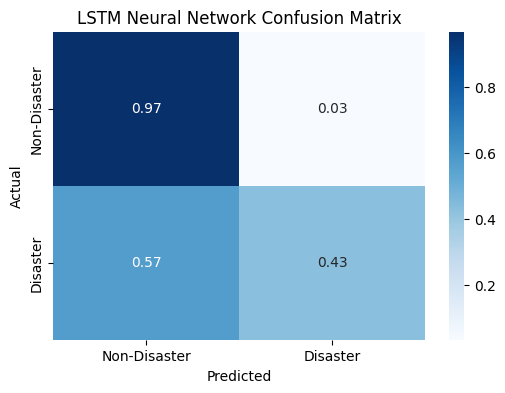

0.8670418571931059


In [27]:
#Plot LSTM Neural Network confusion matrix
predictions = model.predict(X_test)
threshold = 0.5
y_pred = (predictions > threshold).astype(int)
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ['Non-Disaster', 'Disaster']
cf_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize= (6,4))
sns.heatmap(cf_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Neural Network Confusion Matrix')
plt.show()

accuracy = (cf_matrix[0, 0] + cf_matrix[1, 1]) / np.sum(cf_matrix)  # Calculate accuracy

print(accuracy)

In [28]:
# Recurrent Neural Networks : Bidirectional LSTM
# hyperparameters
epochs = 5
batches = 256
steps = len(X_train)//batches

# Data generator
train_generator = data_generator(X_train, y_train, batches, index_embed, "rnn")

# Model architecture
model = Sequential()
# LSTM input layer
model.add(LSTM(128, input_shape=(max_sequence_length, embedding_size),return_sequences=True))
model.add(LSTM(64, input_shape=(max_sequence_length, embedding_size),return_sequences=True))
# Dropout layer to prevent overfitting
model.add(Dropout(0.2))
# Bidirectional LSTM layer for extra context
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
# sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x= train_generator,
          steps_per_epoch= steps,
          epochs= epochs, verbose = 1)

print(model.output)

# save model
joblib.dump(model, "bidirectional_lstm_model.pk1")


Epoch 1/5
33/33 [==============================] - 18s 220ms/step - loss: 0.4779 - accuracy: 0.8017
Epoch 2/5
33/33 [==============================] - 7s 223ms/step - loss: 0.3824 - accuracy: 0.8362
Epoch 3/5
33/33 [==============================] - 7s 209ms/step - loss: 0.3544 - accuracy: 0.8539
Epoch 4/5
33/33 [==============================] - 7s 206ms/step - loss: 0.3480 - accuracy: 0.8546
Epoch 5/5
33/33 [==============================] - 7s 206ms/step - loss: 0.3411 - accuracy: 0.8564
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")


['bidirectional_lstm_model.pk1']

89/89 [==============================] - 4s 26ms/step


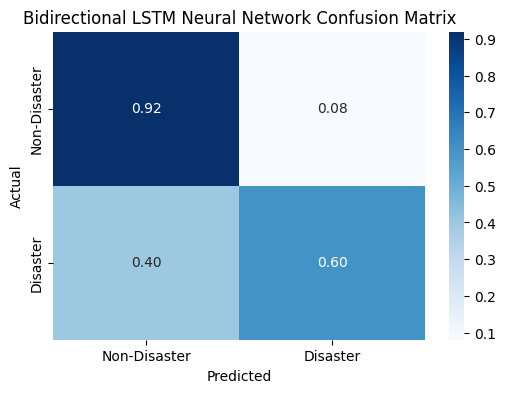

0.861062258177981


In [29]:
#Plot Bidirectional LSTM Neural Network confusion matrix
predictions = model.predict(X_test)
threshold = 0.5
y_pred = (predictions > threshold).astype(int)
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ['Non-Disaster', 'Disaster']
cf_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize= (6,4))
sns.heatmap(cf_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Bidirectional LSTM Neural Network Confusion Matrix')
plt.show()

accuracy = (cf_matrix[0, 0] + cf_matrix[1, 1]) / np.sum(cf_matrix)  # Calculate accuracy

print(accuracy)